# Save/Load Model 

In [ ]:
from keras.models import model_from_json
# Saving Model and weiths
# serialize model to JSON
model_json = model.to_json()
with open("hippo_model_24thJune_NoisleesScrapped_DefaultDBSCAN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("hippo_model_24thJune_NoisleesScrapped_DefaultDBSCAN.h5")
print("Saved model to disk")
 
'''
# load json and create model
json_file = open('hippo_model_20thJune_NoisleesURL_DefaultDBSCAN_SmallEPS.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("hippo_model_20thJune_NoisleesURL_DefaultDBSCAN_SmallEPS.h5")
print("Loaded model from disk")
'''
'''
# Evaluate

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
'''


# HippoData

In [1]:
import numpy as np
from collections import Counter
from operator import itemgetter
from sklearn import metrics



# if you have labels


'''
    The idea of the function below (map_label) is a simplified approach to what they did in the initial paper. 
    They used the so called Hungarian method in order to optimize the labeling. The optimization is based on the
    ground truth and the labels from the k clustering. Using the example dataset:
    We have 20 000 items split in 20 categories, which means that a certain category has multiple items. 
    The idea of best mapping is to take all tuples from ground truth and prediction per item and count their 
    occurancies. For example (6, 18), 88), 6 being the ground truth and 18 the prediction truth. This 
    combination has occured 88 times but ((6, 3), 116) has occured 116 times, so at the end the function 
    will return 6,3 as best map.
'''

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())  #count the appearance of each pair dict principle
    mapping = dict()
    n_label = len(np.unique(true_labels))

    # map most likely labels from prediction to ground truth

    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0] # tuple as input and take the one which appears the most from the list
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

# if you have labels
def cluster_quality(true_labels, pred_labels, show=True):
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    pred_labels_mapped = map_label(true_labels, pred_labels)
    acc = metrics.accuracy_score(true_labels, pred_labels_mapped)
    '''
    # Prints the scores
    if show:
        print("Homogeneity: %0.3f" % h)
        print("Completeness: %0.3f" % c)
        print("V-measure: %0.3f" % v)
        print("NMI: %0.3f" % nmi)
        print("Rand score: %0.3f" % rand)
        print("Accuracy: %0.3f" % acc)
        '''
    return dict(
        homogeneity=round(h,3),
        completeness=round(c,3),
        vmeasure=round(v,3),
        nmi=round(nmi,3),
        rand=round(rand,3),
        accuracy=round(acc,3),
    )


In [2]:
import os

from gensim.models.keyedvectors import KeyedVectors
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

############################
# Loading Data
############################

EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin' # word vectors
#text_path = 'data/StackOverflow.txt'# data without labels
#text_path = 'data/data_NN_URL_No_Noise_Testing.txt' # url keywords no noise
#text_path = 'data/data_NN.txt'# data without labels - Own Data
#text_path = 'data/data_NN_Scrapped.txt'# data without labels - Own Data based on scrapping
#text_path = 'data/data_NN_no_noise_Scrapped - Noisless scrapped.txt'# scrapped data, no noise based on dbscan
text_path = 'data/data_NN_no_noise_Scrapped - Noisless url_keywords.txt'# scrapped data, no noise based on dbscan
#label_path = 'data/StackOverflow_gnd.txt' # labels per row in the data file

with open(text_path) as f:
    data = [text.strip() for text in f]
'''
with open(label_path) as f:
    target = f.readlines()
    
target = [int(label.rstrip('\n')) for label in target] # the data has /n at the end of each row
'''
print("Total: %s short texts" % format(len(data), ","))

Using TensorFlow backend.


Total: 3,537 short texts


In [6]:
############################
# Preprocessing
############################

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data) # replace words/tokens with numbers

word_index = tokenizer.word_index # get the coresponing word:number dict format
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index) # all words - len

seq_lens = [len(s) for s in sequences_full] # get the count of words/symbols in the sequence from above
print("Minumum length: %d" % min(seq_lens))
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH) # uses the len of the list and max len
#y = target # we take the target values

'''
    pad_sequences is used to ensure that all sequences in a list have the same length. By default this 
    is done by padding 0 in the beginning of each sequence until each sequence has the same 
    length as the longest sequence.
'''

Found 283 unique tokens.
Minumum length: 1
Average length: 3
Max length: 27


'\n    pad_sequences is used to ensure that all sequences in a list have the same length. By default this \n    is done by padding 0 in the beginning of each sequence until each sequence has the same \n    length as the longest sequence.\n'

In [7]:
############################
# Preparing embedding matrix
############################


print('Preparing embedding matrix')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # Init as 0's and updated if in word2vec
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    #else:
        #print(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 81


In [9]:
#################################################
# Preparing target using Average embeddings (AE)
#################################################
Y = {}
tfidf_seq = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf') # converting List of sequences (a sequence is a list of integer word indices).
# TF-IDF Acc: 0,329
binary_seq = tokenizer.sequences_to_matrix(sequences_full, mode='binary') # Acc: 0,458
count_seq = tokenizer.sequences_to_matrix(sequences_full, mode='count') # Acc: 0,467
frequency_seq = tokenizer.sequences_to_matrix(sequences_full, mode='freq') # Acc: 0452
from sklearn.preprocessing import Normalizer
normed_value = Normalizer().fit_transform(count_seq)
average_embeddings = np.dot(normed_value, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)


# binary Y
from sklearn import preprocessing
reduction_name = "ae"
B = preprocessing.Binarizer().fit_transform(Y[reduction_name]) # binarizing the whole value list for ae key (which is the only key)

# Shape of last dimension in the CNN
TARGET_DIM = B.shape[1]

# Example of binarized target vector
print(B.shape)
print(B[1])

Shape of average embedding:  (3537, 300)
(3537, 300)
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]


In [10]:
###############PLAYING-GridSearch#################################
# Playing train model
################################################

# Best accuracy for now

import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, concatenate, Input
from keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

#https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
# the above link has to do with dropout positioning

# https://github.com/keras-team/keras/issues/7290
# has to do with spatial dropout after embedding layer

# https://towardsdatascience.com/review-tompson-cvpr15-spatial-dropout-human-pose-estimation-c7d6a5cecd8c
# SpatialDropout again

def get_model():
    embedding_matrix_copy = embedding_matrix.copy()
    trainable_embedding = False
    #filters = [2,3,4]
    filters = [3,4,5]
    
    # Embedding layer
    pretrained_embedding_layer = Embedding(
        input_dim=nb_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
    )

    # Input
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = pretrained_embedding_layer(sequence_input)
    
    # DropOut
    #x = Dropout(0.2)(embedded_sequences)
    spatial_x = SpatialDropout1D(0.1)(embedded_sequences)
    
    # 1st Layer
    conv_layers = []
    for i in filters:
        x = Conv1D(125, i, activation='tanh', padding='same')(spatial_x)
        x = GlobalMaxPooling1D()(x)
        #x = Dropout(0.2)(x)
        conv_layers.append(x)
    merged = concatenate(conv_layers)
    
    # Dense
    #x = Dense(TARGET_DIM,activation = 'tanh')(merged)
    x = Dense(256,activation = 'tanh')(merged) # best performing
    
    # DropOut
    x = Dropout(0.1)(x)
    #x = Dropout(0.1)(merged) # best performing
    
    # Output
    predictions = Dense(TARGET_DIM, activation='sigmoid')(x) 
    # sigmoid because we want 0,1 for one of the categories
    
    model = Model(sequence_input, predictions)

    model.layers[1].trainable=trainable_embedding #embedding layer

    #adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #standard for keras
    #optimizer = Adam(lr=learn_rate)
    
    # Loss and Optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy','mae'])
    
    # Fine-tune embeddings or not
    model.summary()
    plot_model(model, to_file='model_plot_no_shapes.png', show_shapes=False, show_layer_names=True)
    plot_model(model, to_file='model_plot_no_shapes.pdf', show_shapes=False, show_layer_names=True)

    
    return model

In [11]:
from sklearn.preprocessing import normalize
# 25 epoch and 80 batch = 50.3 accuracy
nb_epoch = 12 #changed from 50 cause of time limitations
#nb_epoch = 1
# 5 epochs take 1 hour and 14 mins to load

checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model = get_model()
history = model.fit(X, B, validation_split=0.2,
              epochs=nb_epoch, batch_size=100, verbose=1, shuffle=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 300)      85200       input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 27, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)    

In [8]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

<Figure size 640x480 with 1 Axes>

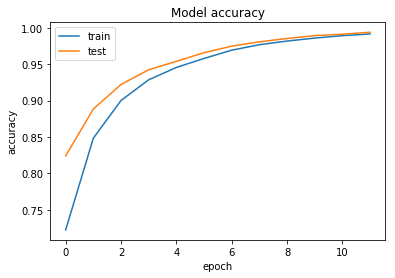

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:

from keras.models import Sequential, Model
# Loaded model
from keras.models import model_from_json
# load json and create model
json_file = open('hippo_model_18thJune_OwnData.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("hippo_model_18thJune_OwnData.h5")
print("Loaded model from disk")

# Preping results

# create model that gives penultimate layer (предпоследно)
input1 = loaded_model.layers[0].input
output = loaded_model.layers[-2].output

model_penultimate = Model(input1, output)


# inference of penultimate layer
H_penul = model_penultimate.predict(X)
print("Sample shape: {}".format(H_penul.shape))

# standard model prediction
H_standard = loaded_model.predict(X)
print("Sample shape for standard: {}".format(H_standard.shape))



Loaded model from disk


ValueError: Error when checking input: expected input_1 to have shape (576,) but got array with shape (27,)

In [13]:
# Preping results

# create model that gives penultimate layer (предпоследно)
input1 = model.layers[0].input
output = model.layers[-2].output

model_penultimate = Model(input1, output)


# inference of penultimate layer
H_penul = model_penultimate.predict(X)
print("Sample shape: {}".format(H_penul.shape))

# standard model prediction
H_standard = model.predict(X)
print("Sample shape for standard: {}".format(H_standard.shape))

Sample shape: (3537, 256)
Sample shape for standard: (3537, 300)


In [11]:
# Testing with max 50 clusters
from sklearn.preprocessing import normalize
#############################
# Applying L2 Normalization #
#############################

# Penul Layer
V_penul = normalize(H_penul, norm='l2') # norm
# With the 10 000 examples, No. Clusters: 49, Silhouette Score: 0.5350000262260437
# Standard Predict
# With the 10 000 examples, No. Clusters: 50, Silhouette Score: 0.5669999718666077
V_standard = normalize(H_standard, norm='l2') # norm

#############################
# gower function equivalent #
#############################
from scipy.spatial.distance import pdist

# Penul Layer
# With the 10 000 examples,
Pdist_penul = pdist(H_penul, metric='euclidean')
# Standard Predict
# With the 10 000 examples,
Pdist_standard = pdist(H_standard, metric='euclidean')

#############################
###### Applying PCA #########
#############################
from sklearn.decomposition import PCA
# Penul Layer
# Make an instance of the Model
# With the 10 000 examples, No. Clusters: 50, Silhouette Score: 0.5690000057220459
pca = PCA(.95)
pca.fit(H_penul)
PCA_penul = pca.transform(H_penul)
# Standard Predict
# Make an instance of the Model
# With the 10 000 examples No. Clusters: 7, Silhouette Score: 0.6079999804496765
pca = PCA(.95)
pca.fit(H_standard)
PCA_standard = pca.transform(H_standard)

In [ ]:
# Amount of Clusters based on Penul data
# Wherever it makes the curve switch - around 6-7 for this data

import numpy as np
from scipy import cluster
from matplotlib import pyplot

#V = normalize(H, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(H_standard,i) for i in range(1,40)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [ ]:
# Amount of Clusters based on standard prediction
# Wherever it makes the curve switch - around 6-7 for this data

import numpy as np
from scipy import cluster
from matplotlib import pyplot

#V = normalize(H, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(V_standard,i) for i in range(1,40)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [ ]:
# Penul Layer

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

#№true_labels = y
#n_clusters = len(np.unique(y))
n_clusters = 19 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_penul = dict()
#V_penul = normalize(H_penul, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
km.fit(V_penul)
pred_penul = km.labels_
pred1_penul = km.cluster_centers_
print(pred_penul)
#a = cluster_quality(true_labels, pred_penul) #needs labels
#np.save("pred.npy", pred)
#print(a)

In [ ]:
# Standard Layer

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

#№true_labels = y
#n_clusters = len(np.unique(y))
n_clusters = 9 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_penul = dict()
#V_penul = normalize(H_penul, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
km.fit(V_standard)
pred_standard = km.labels_
pred1_standard = km.cluster_centers_
print(pred_standard)
#a = cluster_quality(true_labels, pred_penul) #needs labels
#np.save("pred.npy", pred)
#print(a)

# DBSCAN - Penul and Standard Layer

In [ ]:
#################################################
################Visualization####################
#################################################

Estimated number of clusters: 101
Estimated number of noise points: 45
Silhouette Coefficient: 0.977


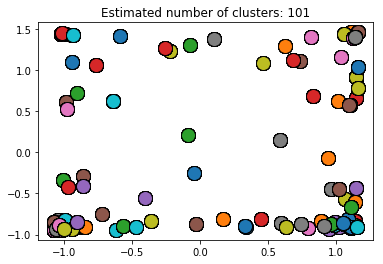

In [12]:

# DBSCAN for penul layer based on scrapped keywords

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################


X_DBSCAN = StandardScaler().fit_transform(H_penul)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples= 10).fit(H_penul)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
'''
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pred_penul, labels))
print("Completeness: %0.3f" % metrics.completeness_score(pred_penul, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(pred_penul, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(pred_penul, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(pred_penul, labels,
                                           average_method='arithmetic'))
                                           '''
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_DBSCAN, labels))

# #############################################################################
# Plot result - DBSCAN
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_DBSCAN[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markeredgecolor='k', markersize=14)

    #xy = X_DBSCAN[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o',
     #        markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 101
Estimated number of noise points: 0
Silhouette Coefficient: 1.000


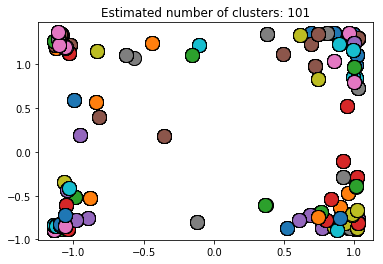

In [13]:

# DBSCAN for standard prediction based on scrapped keywords

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################


X_DBSCAN = StandardScaler().fit_transform(H_standard)

# #############################################################################
# Compute DBSCAN
#db = DBSCAN(eps=0.5, min_samples= 4).fit(H_standard)
#db = DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',metric_params=None, min_samples=2, n_jobs=-1).fit(H_standard) #sklearn defaut example 1
#db = DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',metric_params=None, min_samples=5, n_jobs=-1).fit(H_standard) #sklearn defaut example 2
db = DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',metric_params=None, min_samples=10, n_jobs=-1).fit(H_standard) #sklearn defaut example 2
#3rd option is not that good
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
'''
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pred_standard, labels))
print("Completeness: %0.3f" % metrics.completeness_score(pred_standard, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(pred_standard, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(pred_standard, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(pred_standard, labels,
                                           average_method='arithmetic'))
                                            '''
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_DBSCAN, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_DBSCAN[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markeredgecolor='k', markersize=14)

    #xy = X_DBSCAN[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o',
     #        markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Silhoette - Penul and Standard With Noise

In [ ]:
#################################################
################Evaluation####################
#################################################

In [ ]:

# Running the results from standard prediction based on Scrapped Keywords

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('ScrappedKeywords_StandardPrediction100_WorkingOnEval.pdf')


range_n_clusters = []
for i in range(2,101): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(V_standard) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_standard)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_standard, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_standard, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_standard[:, 0], V_standard[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

In [ ]:

# Running the results from penul layer from Scrappe Keywords

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('ScrappedKeywords_PenulLayer100_WorkingOnEval.pdf')


range_n_clusters = []
for i in range(2,101): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(V_penul) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_penul)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_penul, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_penul, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_penul[:, 0], V_penul[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

# GLS - Standard and Penul Layers - with noise (Also just sil score no plots)

In [ ]:
# The GLS tells the best amount of clusters

In [ ]:
# Standard Layer
from gls import gaussian_likelihood_score, find_best_cluster
from sklearn.cluster import AgglomerativeClustering

# get score for each possible k
gls_scores = []
#gls_scores_dict = {}
for i in range(2, 50):
    clusterer = AgglomerativeClustering(n_clusters=i).fit(V_standard)
    labels = clusterer.labels_
    # append score for the hypothesis `i`
    gls_scores.append(gaussian_likelihood_score(V_standard, labels))
    #gls_scores_dict[i] = gaussian_likelihood_score(V_standard, labels)
    
# find best cluster. `+ 2` because we start with i == 2
guess = find_best_cluster(gls_scores) + 2
print(f"GLS guess: {guess}")
#print("GLS score: {}".format(gls_scores_dict[guess]))


In [ ]:
# Penul Layer
from gls import gaussian_likelihood_score, find_best_cluster
from sklearn.cluster import AgglomerativeClustering

# get score for each possible k
gls_scores = []
for i in range(2, 50):
    clusterer = AgglomerativeClustering(n_clusters=i).fit(V_penul)
    labels = clusterer.labels_
    # append score for the hypothesis `i`
    gls_scores.append(gaussian_likelihood_score(V_penul, labels))

# find best cluster. `+ 2` because we start with i == 2
guess = find_best_cluster(gls_scores) + 2
print(f"GLS guess: {guess}")

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
def optimal_kmeans(dataset, start=2, end=121):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values and line plot of Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
        silhouette_avg = round(silhouette_score(dataset, labels, random_state=1), 3)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(150,70)) # 22 20 120 50 220 90
            #plt.tick_params(labelsize=24) # was 12
            #plt.title('Silhouette Score for different cluster values', fontsize = 40)
            #sns.pointplot(x=n_clu, y=km_ss)
            b = sns.pointplot(x=n_clu, y=km_ss)
            ''''
            used for thesis
            # skipping even labels
            labels = b.get_xticklabels() # get x labels
            for i,l in enumerate(labels):
                if(i%2 == 0): labels[i] = '' # skip even labels
            b.set_xticklabels(labels,rotation=40) # set new labels
            # till here
            
            # Plot charac
            b.axes.set_title("Silhouette Score for different cluster values",fontsize=120)
            b.set_xlabel("Number of Clusters",fontsize=100)
            b.set_ylabel("Silhouette Score",fontsize=100)
            b.tick_params(labelsize=70)
            
            #plt.savefig('silhouette_score.png', format='png', dpi=400)
            #plt.tight_layout()
            #plt.savefig('silhouette_score.png', format='png')
            plt.show()
            '''
            #new
            # skipping even labels

            labels = b.get_xticklabels() # get x labels
            for i,l in enumerate(labels):
                if(i%10 != 0): labels[i] = '' # skip even labels
            b.set_xticklabels(labels,rotation=40) # set new labels
            # till here
            
            # Plot charac
            b.axes.set_title("Silhouette Score for different cluster values, starting from 2 until 120",fontsize=120)
            b.set_xlabel("Number of Clusters",fontsize=100)
            b.set_ylabel("Silhouette Score",fontsize=100)
            b.tick_params(labelsize=90)
            
            #plt.savefig('silhouette_score.png', format='png', dpi=400)
            #plt.tight_layout()
            #plt.savefig('silhouette_score.png', format='png')
            plt.show()

In [ ]:
optimal_kmeans(H_penul)

In [ ]:
from sklearn.manifold import TSNE
def kmeans(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    '''
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    '''
    return df_new, cluster_labels

In [ ]:
type(V_standard)

In [ ]:
import pandas as pd
df = pd.DataFrame(data=V_standard)

#print(df)

In [ ]:
dfne,s= kmeans(df,9)

In [ ]:
dfne

In [ ]:
s

# Storing Locally

In [ ]:
data[1]

In [ ]:
sequences_full[1]

In [ ]:
X[1]

In [ ]:
H_standard[1]

In [ ]:
V_standard[1]

In [ ]:
pred_standard[1]

In [ ]:
pred1_standard[1]

In [ ]:
keywords_list = d["Keywords"].tolist()

In [ ]:
import pandas as pd
d = []
for i in range(len(data)):
    #d.append({'Keywords_CNN': data[i], 'Sequence_Full': sequences_full[i], 'Prediction':b[i]}) # for merged
    d.append({'Keywords_CNN': data[i], 'Sequence_Full': sequences_full[i], 'Prediction':labels[i]})
d = pd.DataFrame(d)
#d['keywords'] = d.apply(lambda x: x['Keywords_CNN'].split(), axis = 1) # for merged
#d.sort_values('Prediction')
d.head(1)
#d.to_csv('CNN_Demo-HippoBased_Test.csv')

In [ ]:
d.reset_index().plot.scatter(x='index', y='Prediction')

In [ ]:
d["Prediction"].value_counts().plot.bar()

In [ ]:
d.sort_values('Prediction')

In [ ]:
# - 1 for outliers based on DBSCAN
d = d[d.Prediction != -1]

# NoNoise

In [ ]:
importName = 'CNN_Demo-HippoBased_Labels.xls'
cluster_labels = pd.read_excel(importName)

In [ ]:
# Make for data Model using the scrapped keywords
keywords_list = d["Keywords_CNN"].tolist()
data_NN_no_noise = []
for i in keywords_list:
    data_NN_no_noise.append(i)
with open('data_NN_URL_No_Noise_Testing.txt', 'w') as f:
    for item in data_NN_no_noise:
        f.write("%s\n" % item)

# Remove Noise

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

n_clusters = 7 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_penul = dict()
km.fit(PCA_standard)
pred_standard_PCA = km.labels_
pred1_standard_PCA = km.cluster_centers_
print(pred_standard_PCA)
from collections import Counter, defaultdict
a = Counter(km.labels_)

In [ ]:
size_dict = {}
for i in a.keys():
    size_dict[i] = a[i]

In [ ]:
size_dict

# Test George

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
init_variable = H_standard
pair_dist = pairwise_distances(init_variable,metric='euclidean', n_jobs=-1)

In [ ]:
import matplotlib.cm as cm
range_n_clusters = range(27, 28)
# a is the pre-computed matrix using the gower coefficient, using the daisy function in R.

for n_clusters in range_n_clusters:

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(22, 14)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(init_variable) + (n_clusters + 1) * 10])
    kmodes_cao = KMeans(n_clusters=n_clusters, verbose=0)
    kmodes_cao.fit_predict(init_variable)


    b = kmodes_cao.labels_
    silhouette_avg = silhouette_score(pair_dist, b, metric='precomputed')

    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(pair_dist, b, metric='precomputed')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[b == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(("Silhouette analysis for KModes clustering "
                  "with clusters = %d" % n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)
    
    
    # Draw white circles at cluster centers
    #plt.savefig('silhouette_score_bars.png', format='png', dpi=400)
    plt.show()

In [ ]:
b

# Merge

In [ ]:
# Merge the visitor data with clusters

In [ ]:
import pandas as pd

In [ ]:
importName = 'data/ForEvaluation.csv'
user_data_import = pd.read_csv(importName, sep=',')

In [ ]:
user_data_import = user_data_import.drop('Unnamed: 0', 1)
user_data_import.head(1)

In [ ]:
d.head(1)

In [ ]:
# clean dict from cnn
new_d = dict(zip(d.Prediction,d.keywords))

In [ ]:
# clean dict with visitor
new_user_data_import = dict(zip(user_data_import.transactionPath,user_data_import.keywords))

In [ ]:
new_user = {}
for key,value in new_user_data_import.items():
    dataOutput = eval(value) # How to convert list lookalike into a list?
    new_user[key] = dataOutput

In [ ]:
# dummy

In [ ]:
# merging
merged_data = user_data_import.sort_values('keywords', ascending=False)
merged_data["Numeric_Label"] = merged_data['visitorId']
d.reset_index(drop=True)
merged_data.reset_index(drop=True)
merged_data.head(1)

In [ ]:
from collections import defaultdict
# cluster_labels_dict
cluster_labels_dict = defaultdict(list)
list1 = d['Prediction'].tolist()
list2 = d['keywords'].tolist()
for key, value in zip(list1, list2):
    cluster_labels_dict[key].append(value)

In [ ]:
result_dict = {}
for key, value in cluster_labels_dict.items():
    for i in value:
        for key_clean, value_clean in new_user.items():
            if sorted(value_clean) == sorted(i):
                #print('I am first: {}'.format(i))
                #print('I am second:{}'.format(value_clean))
                result_dict[key_clean] = key

In [ ]:
#merged_data["Numeric_Label"].replace(result_dict, inplace=True) # they do the same
merged_data['Numeric_Label'] = merged_data['transactionPath'].map(result_dict)
merged_data['Numeric_Label'].fillna('missing', inplace=True)
merged_data = merged_data.reset_index(drop=True)
merged_data.to_csv('CNN_Merge_Test.csv')